# Model selection during limb development

Limb development is controlled by multiple key transcription factors (TFs). In this section, we will use `ModelComparison` to evaluate different model training strategies. The best-performing model will then be used to simulate the knockout of specific TFs, allowing us to observe their potential effects on the developmental process.

### Library import

In [1]:
# Basic packages
import numpy as np
import pandas as pd
import scipy
import torch
import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from scipy.stats import ttest_ind

# RegVelo and related package
import scanpy as sc
import cellrank as cr
import scvi
import regvelo as rgv
from regvelo import REGVELOVI
import scvelo as scv
from regvelo import ModelComparison # Import ModelComparison
from regvelo.tools.set_output import set_output


# Initialize random seed
scvi.settings.seed = 0

# Data loading
adata = sc.read_h5ad("/home/huang/RegVelo/data/adata_processed_velo.h5ad")
adata

/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound
Seed set to 0


AnnData object with n_obs × n_vars = 12207 × 606
    obs: 'percent_mito', 'n_counts', 'n_genes', 'doublet_scores', 'bh_pval', 'adj_stage', 'adj_sample', 'leiden', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'leiden_R_celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'velocity_genes', 'TF'
    uns: 'adj_stage_colors', 'celltype_sizes', 'diffmap_evals', 'draw_graph', 'leiden', 'leiden_R_celltype_colors', 'leiden_R_colors', 'leiden_sizes', 'log1p', 'marker_m_leiden_R_celltype', 'neighbors', 'network', 'paga', 'pca', 'phase_colors', 'rank_genes_groups', 'regulators', 'skeleton', 'targets', 'umap'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_umap'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

The downsampling applied here is due to GPU memory constraints. As a result, the final outcomes may differ from those reported in published studies.

In [19]:
# refer Real_Time key
adata.obs['adj_stage_num'] = adata.obs['adj_stage'].str.replace('Pcw', '').astype(float)
adata.uns['skeleton'] = adata.uns['skeleton'].astype(np.float32)

np.random.seed(0)
adata.obs['down_samp'] = False
selected = np.random.choice(adata.obs_names, size=2000, replace = False)
adata.obs.loc[selected, 'down_samp'] = True
adata_cp = adata[adata.obs['down_samp']].copy()
adata_cp

AnnData object with n_obs × n_vars = 2000 × 606
    obs: 'percent_mito', 'n_counts', 'n_genes', 'doublet_scores', 'bh_pval', 'adj_stage', 'adj_sample', 'leiden', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'leiden_R_celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'adj_stage_num', 'down_samp'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'velocity_genes', 'TF'
    uns: 'adj_stage_colors', 'celltype_sizes', 'diffmap_evals', 'draw_graph', 'leiden', 'leiden_R_celltype_colors', 'leiden_R_colors', 'leiden_sizes', 'log1p', 'marker_m_leiden_R_celltype', 'neighbors', 'network', 'paga', 'pca', 'phase_colors', 'rank_genes_groups', 'regulators', 'skeleton', 'targets', 'umap'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_umap'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

### ModelComparison

In [3]:
TERMINAL_STATES = ['PAX7+MyoProg1',"MYH3+MyoC","MYL3+MyoC"]
n_STATES = 8
comp=ModelComparison(terminal_states=TERMINAL_STATES, n_states=n_STATES)
comp.train(adata=adata_cp, 
           model_list=['soft','hard','soft_regularized'],
           lam2=[1.0],
           n_repeat=3,
           batch_size=3000)

Seed set to 0
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is availab

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Seed set to 1
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is availab

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1698.260. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Seed set to 2
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is availab

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1714.467. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Seed set to 0
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is availab

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1698.773. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Seed set to 1
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is availab

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1714.557. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Seed set to 2
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is availab

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1661.939. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Seed set to 0
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is availab

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1647.732. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Seed set to 1
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is availab

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1452.538. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Seed set to 2
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is availab

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1326.535. Signaling Trainer to stop.


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1449.679. Signaling Trainer to stop.


['soft_0',
 'soft_1',
 'soft_2',
 'hard_0',
 'hard_1',
 'hard_2',
 'soft_regularized\nlam2:1.0_0',
 'soft_regularized\nlam2:1.0_1',
 'soft_regularized\nlam2:1.0_2']

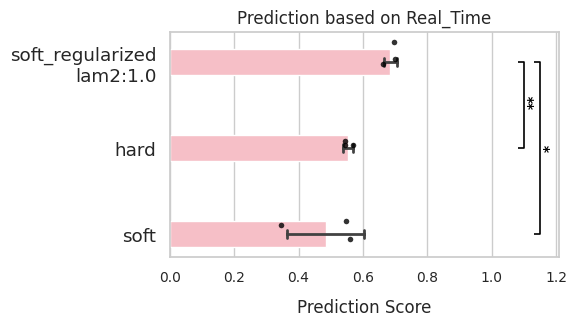

In [4]:
comp.evaluate(side_information='Real_Time',
              side_key='adj_stage_num')
comp.plot_results(side_information='Real_Time')

In [5]:
comp.df_Real_Time

,Model,Corr,Run
0,soft,0.547515,0
1,soft,0.559556,1
2,soft,0.344471,2
3,hard,0.543533,0
4,hard,0.569959,1
5,hard,0.543849,2
6,soft_regularized\nlam2:1.0,0.699106,0
7,soft_regularized\nlam2:1.0,0.695861,1
8,soft_regularized\nlam2:1.0,0.660618,2


From these results, we can see that the best-performing model is soft_regularized with lambda2 = 1, which achieves the highest prediction score while maintaining relatively good stability.

Finally we try to use soft_regularized lam2:1.0_1 as our model and save it for following analysis

In [6]:
vae_sr1 = comp.MODEL_TRAINED['soft_regularized\nlam2:1.0_1']
vae_sr1.save('vae_sr1')

### Downstream analysis

In this section, we will conduct downstream analyses, including:

* Simulating cell differentiation

* Performing TF knockout perturbations

* Predicting biological outcomes

In [20]:
# Reload selected model
vae_sr1 = REGVELOVI.load('vae_sr1', adata_cp)
set_output(adata_cp, vae_sr1, n_samples=30, batch_size=adata_cp.n_obs)

INFO     File vae_sr1/model.pt already downloaded                                                                  


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...


### Simulation of developing process by velocity graph

After loading the model, we can first examine the velocity plot. Note that due to the downsampling mentioned earlier, we need to recalculate cell neighborhoods, which are then integrated with the velocity estimation.

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/128 cores)


  0%|          | 0/2000 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_draw_graph_fa', embedded velocity vectors (adata.obsm)


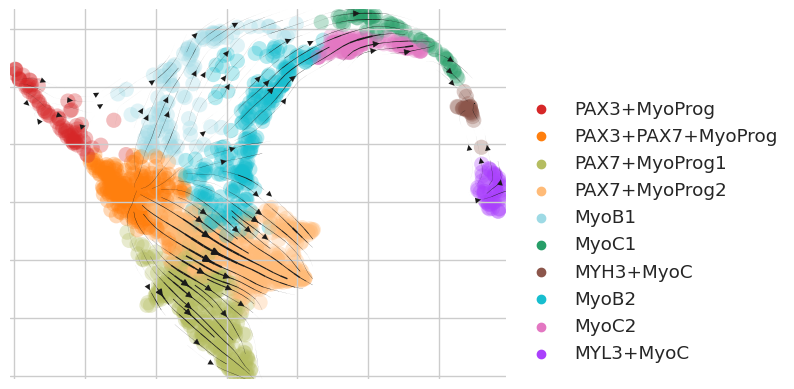

In [22]:
scv.pp.neighbors(adata_cp)
scv.tl.velocity_graph(adata_cp)
scv.pl.velocity_embedding_stream(adata_cp, basis="draw_graph_fa", title="", legend_loc="lower right",color = "leiden_R_celltype")


### In silico peritubation

In this section, we sequentially knock down two transcription factors (TFs), MSC and MYOG, to examine their effects on cell fate determination. This analysis can be performed using the following functions:

* `regvelo.tl.in_silico_block_simulation`

* `regvelo.tl.depletion_score`

In [ ]:
# Computing states transition probability
vk = cr.kernels.VelocityKernel(adata_cp)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_cp).compute_transition_matrix()
estimator = cr.estimators.GPCCA(0.8*vk + 0.2*ck)
estimator.compute_macrostates(n_states=8, cluster_key='leiden_R_celltype')
estimator.set_terminal_states(TERMINAL_STATES)
estimator.compute_fate_probabilities()

  0%|          | 0/2000 [00:00<?, ?cell/s]

  0%|          | 0/2000 [00:00<?, ?cell/s]

  0%|          | 0/3 [00:00<?, ?/s]

In [24]:
adata_pert_dict = {}
TF_list = ['MSC','MYOG']
for TF in TF_list:
    model = 'vae_sr1'
    adata_target_pert, reg_vae_pert = rgv.tl.in_silico_block_simulation(model=model,
                                                                        adata=adata_cp,
                                                                        TF = TF,
                                                                        cutoff=0)
    adata_pert_dict[TF] = adata_target_pert

INFO     File vae_sr1/model.pt already downloaded                                                                  


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...


INFO     File vae_sr1/model.pt already downloaded                                                                  


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...


In [25]:
df, adata_pert_dict = rgv.tl.depletion_score(perturbed=adata_pert_dict,
                                             baseline=adata_cp,
                                             terminal_state=TERMINAL_STATES,
                                             n_states = 8,
                                             cluster_key = "leiden_R_celltype")
df

  0%|          | 0/2000 [00:00<?, ?cell/s]

  0%|          | 0/2000 [00:00<?, ?cell/s]

  0%|          | 0/3 [00:00<?, ?/s]

  0%|          | 0/2000 [00:00<?, ?cell/s]

  0%|          | 0/2000 [00:00<?, ?cell/s]

  0%|          | 0/3 [00:00<?, ?/s]

,Depletion score,p-value,FDR adjusted p-value,Terminal state,TF
0,-0.196511,5.200994e-27,5.200994e-27,PAX7+MyoProg1,MSC
1,0.209996,1.311690e-30,1.967535e-30,MYH3+MyoC,MSC
2,-0.327238,8.035312e-72,2.410594e-71,MYL3+MyoC,MSC
0,0.604097,5.108021e-240,7.662031e-240,PAX7+MyoProg1,MYOG
1,-0.614170,5.119658e-248,1.535897e-247,MYH3+MyoC,MYOG
2,-0.505604,9.313492e-169,9.313492e-169,MYL3+MyoC,MYOG


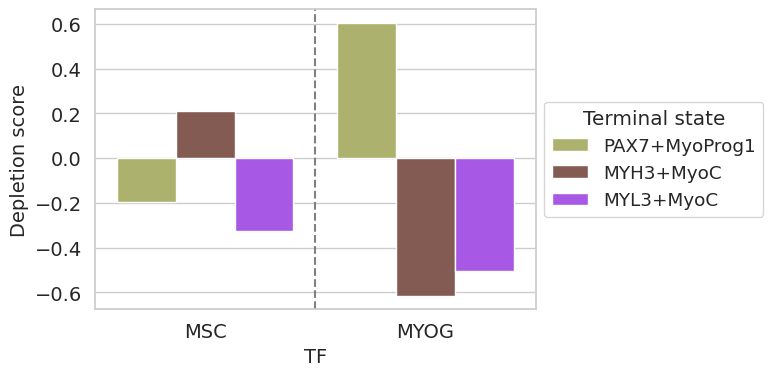

In [26]:
rgv.pl.depletion_score(adata=adata_cp,
                       df=df,
                       fontsize=14,
                       figsize = (8,4),
                       legend_loc='center left',
                       legend_bbox = (1.02, 0.5),
                       xlabel='TF',
                       ylabel = "Depletion score",
                       color_label="leiden_R_celltype")

### Gene expression prediction under pertubation

After generating perturbation data with `regvelo.tl.in_silico_block_simulation`, users can predict gene expression levels using `rgv_expression_fit`. In this section, we selected three representative genes to visualize the perturbation effects.

In [27]:
Ms,Mu = vae_sr1.rgv_expression_fit(return_numpy=True,n_samples = 30)
adata_cp.layers["fit_s"] = Ms
adata_cp.layers["fit_u"] = Mu
adata_perturb, vae_perturb = rgv.tl.in_silico_block_simulation('vae_sr1', adata_cp, "MSC", effects= 0)
adata_perturb.layers["fit_s"],adata_perturb.layers["fit_u"] = vae_perturb.rgv_expression_fit(n_samples = 30)

INFO     File vae_sr1/model.pt already downloaded                                                                  


/home/huang/miniforge3/envs/regvelo-py310/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/huang/miniforge3/envs/regvelo-py310/lib/python ...


In this section, we first define two supporting functions:

* `add_significance`

* `get_significance`

These functions will be used to plot significance bars between groups in subsequent analysis.

In [ ]:
from typing import Dict, List, Tuple
import anndata
from matplotlib.axis import Axis


def add_significance(
    ax: Axis, left: int, right: int, significance: str, level: int = 0, orientation: str = "horizontal", **kwargs
) -> None:
    """Add significance bracket to Matplotlib Axis plot.

    Parameters
    ----------
    ax
        Matplotlib axis.
    left
        Position of left (top) subplot.
    right
        Position of right (bottom) subplot.
    siginifcance
        Significance ID to plot.
    level
        Level of bracket.
    orientation
        Orientation of bracket.
    **kwargs
        Keyword arguments passed to Axis.plot and to specify bracket level (`bracket_level`) and height
        (`bracket_height`), and distance between text and bracket (`text_height`).

    Returns
    -------
    None.
    """
    bracket_level = kwargs.pop("bracket_level", 1)
    bracket_height = kwargs.pop("bracket_height", 0.02)
    text_height = kwargs.pop("text_height", 0.01)

    if orientation == "horizontal":
        bottom, top = ax.get_ylim()
    else:
        bottom, top = ax.get_xlim()
    axis_range = top - bottom

    bracket_level = (axis_range * 0.07 * level) + top * bracket_level
    bracket_height = bracket_level - (axis_range * bracket_height)

    if orientation == "horizontal":
        ax.plot([left, left, right, right], [bracket_height, bracket_level, bracket_level, bracket_height], **kwargs)
        ax.text(
            (left + right) * 0.5,
            bracket_level + (axis_range * text_height),
            significance,
            ha="center",
            va="bottom",
            c="k",
        )
    else:
        ax.plot([bracket_height, bracket_level, bracket_level, bracket_height], [left, left, right, right], **kwargs)
        ax.text(
            bracket_level + (axis_range * text_height),
            (left + right) * 0.5,
            significance,
            va="center",
            ha="left",
            c="k",
            rotation=-90,
        )

def get_significance(pvalue: float) -> str:
    """Return significance stars based on p-value."""
    if pvalue < 0.001:
        return "***"
    if pvalue < 0.01:
        return "**"
    if pvalue < 0.05:
        return "*"
    return "ns"

/tmp/ipykernel_3184560/2080288333.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', rotation_mode = 'anchor')


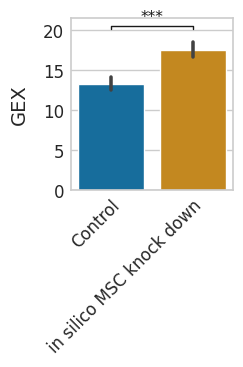

/tmp/ipykernel_3184560/2080288333.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', rotation_mode = 'anchor')


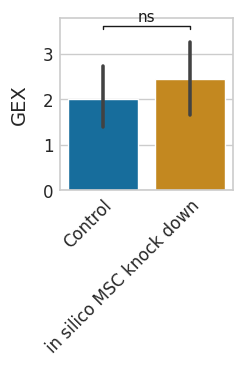

/tmp/ipykernel_3184560/2080288333.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', rotation_mode = 'anchor')


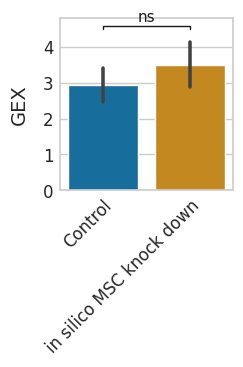

In [28]:

genes = ["MYOG", "MYH3", "TNNT1"]

for g in genes:
    df = pd.DataFrame(
        {
            "GEX": adata_cp[:,g].layers["fit_s"].flatten().tolist() + adata_perturb[:,g].layers["fit_s"].flatten().tolist(),
            "Condition": ["Control"] * adata_cp.shape[0] + ["in silico MSC knock down"] * adata_cp.shape[0],
        }
    )
    df["GEX"] = df["GEX"] * np.max(adata_cp[:,g].layers["spliced"])
    
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(3, 4))

        sns.barplot(data=df, x="Condition", y="GEX", palette="colorblind", ax=ax)
        
        ax.set_ylabel("GEX", labelpad=10)
        ax.set_xlabel("")
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', rotation_mode = 'anchor')
        plt.tight_layout(pad=2)
        ttest_res = ttest_ind(
            adata_perturb[:,g].layers["fit_s"].flatten().tolist(), 
            adata_cp[:,g].layers["fit_s"].flatten().tolist(), 
            alternative="greater"
        )
        significance = get_significance(ttest_res.pvalue)
        add_significance(
            ax=ax,
            left=0,
            right=1,
            significance=significance,
            lw=1,
            bracket_level=1.05,
            c="k",
            level=0,
        )
    
        plt.show()